# Azted G-dDT Single Custom Run

In [1]:
import seaborn as sns
import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pandas as pd
import sys
sys.path.append('../')


pio.renderers.default = "png"

For individual custom runs, the following parameters can currently be adjusted through custom run arguments:


'SINGLE_RUN_PARAMS = AztecModelParams(

    label="default",
    timestep_in_blocks=1,
    uncle_count=0,
    fee_subsidy_fraction=1.0,  # unused
    minimum_stake=30,
    l1_blocks_per_day=int(24 * 60 * 60 / 12.08),
    daily_block_reward=32,
    # Phase Durations
    phase_duration_proposal_min_blocks=0, 
    phase_duration_proposal_max_blocks=10,  
    phase_duration_reveal_min_blocks=0,  
    phase_duration_reveal_max_blocks=10, 
    phase_duration_commit_bond_min_blocks=0,  
    phase_duration_commit_bond_max_blocks=10, 
    phase_duration_rollup_min_blocks=0,  
    phase_duration_rollup_max_blocks=30,  
    phase_duration_race_min_blocks=0,  
    phase_duration_race_max_blocks=30, 

    stake_activation_period=40,  
    unstake_cooldown_period=40,  
    # Behavioral Parameters
    final_probability=0.99,
    gas_threshold_for_tx=220,  
    blob_gas_threshold_for_tx=220, 
    proving_marketplace_usage_probability=0.3,
    rewards_to_provers=0.3,  
    rewards_to_relay=0.01,
    gwei_to_tokens=1e-9,
    gas_estimators=DEFAULT_DETERMINISTIC_GAS_ESTIMATOR,
    tx_estimators=DEFAULT_DETERMINISTIC_TX_ESTIMATOR,
    slash_params=SLASH_PARAMS,
    gas_fee_l1_time_series=GAS_FEE_L1_TIME_SERIES_LIST[-1],
    gas_fee_blob_time_series=GAS_FEE_BLOB_TIME_SERIES_LIST[-1],
    commit_bond_amount=10.0,  
    op_costs=0,  
)


In [8]:
from aztec_gddt.experiment import custom_run
from aztec_gddt.params import *
from aztec_gddt.types import *


params_to_modify = {'gas_threshold_for_tx': [200], 'blob_gas_threshold_for_tx': [210], 'daily_block_reward': [
    32], 'final_probability': [0.95], 'commit_bond_amount': [3]}

N_timesteps = 1000
N_samples = 1

sim_df = custom_run(N_timesteps=N_timesteps,
                    N_samples=N_samples, params_to_modify=params_to_modify)

c:\Users\jhack\Documents\PyProgrs\aztec-gddt\notebooks\..\aztec_gddt\utils\sim_run.py:125: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



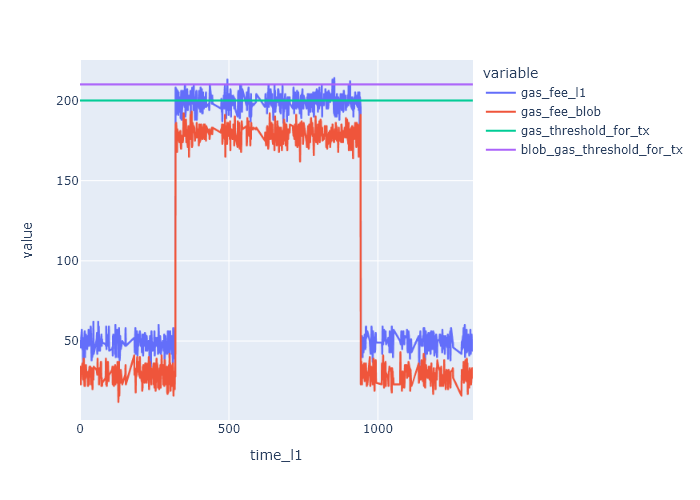

In [9]:
px.line(sim_df,
           x='time_l1',
        y=['gas_fee_l1', 'gas_fee_blob', 'gas_threshold_for_tx', 'blob_gas_threshold_for_tx'])

In [10]:
sim_df.iloc[-1]

subset                                                                                   0
simulation                                                                               0
run                                                                                      1
timestep                                                                              1000
time_l1                                                                               1319
delta_l1_blocks                                                                          0
advance_l1_blocks                                                                        0
slashes_to_provers                                                                     1.0
slashes_to_sequencers                                                                 16.0
total_rewards_provers                                                             2.496644
total_rewards_relays                                                              0.083221

In [ ]:
fig_df = sim_df.copy()
fig_df['process_order'] = fig_df.current_process.map(
    lambda x: x.phase.value if x is not None else None)
fig_df['process_label'] = fig_df.current_process.map(
    lambda x: x.phase.name if x is not None else None)
# .query("time_l1 > 320 & time_l1 < 370")
fig_df = fig_df.sort_values(['process_order', 'timestep'])


plt.figure(figsize=(15, 5))
sns.lineplot(x=fig_df.time_l1,
             y=fig_df.process_label)

plt.figure(figsize=(15, 5))
sns.scatterplot(x=fig_df.time_l1,
                y=fig_df.process_label)
plt.show()

In [ ]:
fig_df.proposal_tx_count

In [ ]:
sns.lineplot(x=sim_df.timestep, y=sim_df.time_l1)

In [ ]:
sim_df.head(-1)

In [ ]:
sns.lineplot(x=sim_df.time_l1, 
             y=sim_df.finalized_blocks_count)

In [ ]:
sns.lineplot(x=sim_df.time_l1, 
             y=sim_df.cumm_block_rewards)

In [ ]:
px.histogram(sim_df,
        x=['gas_fee_l1'])

In [ ]:
ts_df = sim_df.token_supply.apply(lambda x: pd.Series(x.__dict__))
ts_df.plot(kind='line')
plt.title("Token Supply")
plt.show()